# Synthetic dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import shap

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 16

def plot_contribution(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None, cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i),fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
        else:
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='x', colors=(0,0,0,0))
            ax.tick_params(axis='y', colors=(0,0,0,0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.png', bbox_inches='tight')

## Data generation

In [3]:
size = 50

b0 = np.ones((size, size))
b1 = np.ones((size, size))
b2 = np.ones((size, size))
b3 = np.ones((size, size))
b4 = np.ones((size, size))
noise = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b0[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 15**2))
        b1[i, j] = i / 49 * 6
        b2[i, j] = (i + j) / 49 * 3
        b3[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 12**2))
        # b3[i, j] = (j / 49) * 6
        # b3[i, j] = 6 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 6 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))
        noise[i, j] = 4 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 4 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))

# b3 = np.flip(b2, axis=1).T
# b3 = np.ones(size*size).reshape(-1)*2


In [4]:
# b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = b3.reshape(-1)
# b4 = b4.reshape(-1)
noise = noise.reshape(-1)

In [5]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)
X5 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4, X5]).T
u = np.array([np.linspace(0,size - 1,num=size)] * size).reshape(-1)
v = np.array([np.linspace(0,size - 1,num=size)] * size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1]
n = X.shape[0]

In [6]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1), columns=['X1', 'X2', 'X3', 'X4', 'X5', 'x_coord', 'y_coord'])

In [7]:
X_coords

X1        X2        X3        X4        X5  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011  1.623438      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414  1.663881      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029 -0.209243      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231  0.540090      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233 -0.125796      4.0      0.0
...        ...       ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451 -1.925222     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732  0.100871     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266  0.610802     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300  1.650016     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717  1.276653     49.0     49.0

[2500 rows x 7 columns]

In [8]:
# f0 = b0
f1 = b1 * X_coords.values[:, 0]
f2 = b2 * X_coords.values[:, 1]
f3 = b3 * X_coords.values[:, 2]
f4 = X_coords.values[:, 3] * 2
f5 = X_coords.values[:, 4] ** 2

In [9]:
y = pd.DataFrame(f1 + f2 + f3 + f4 + f5 + noise, columns=['y'])

In [10]:
b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5], noise]

In [11]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$', 'noise']

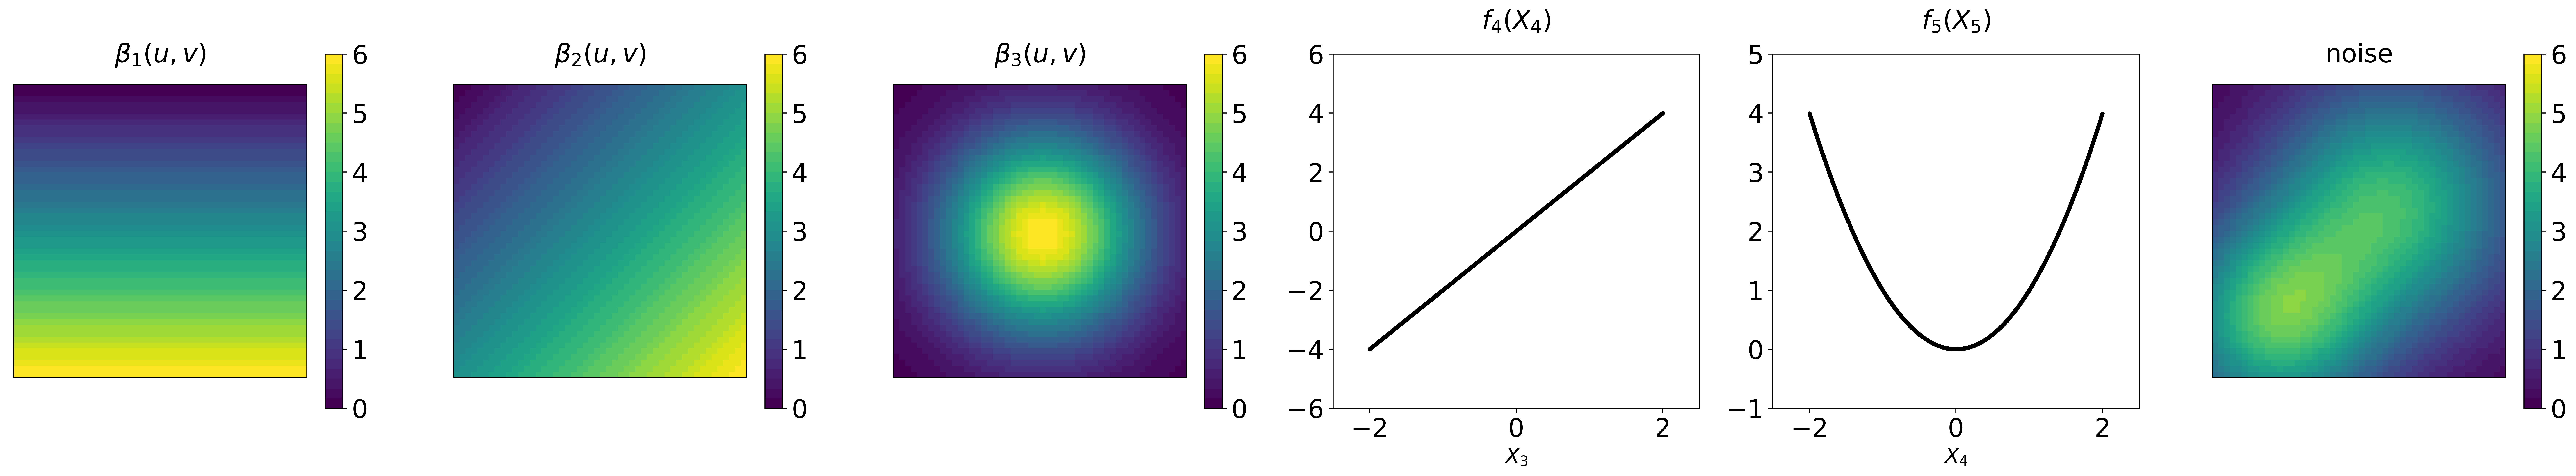

In [12]:
plot_contribution(b=b, k=6, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation', non_spatial=[3, 4])

In [13]:
class Model:
    def __init__(self, f):
        self.predict = f

In [14]:
def predict_with_uncertainty(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 2]
        f4 = X_coords[i, 3] * 2
        f5 = X_coords[i, 4] ** 2
        noise = 4 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 4 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))

        # y = f0 + f1 + f2 + f3 + f4
        y = f1 + f2 + f3 + f4 + f5 + noise
        y_pred.append(y)
    return np.array(y_pred)

In [15]:
def predict_without_uncertainty(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 2]
        f4 = X_coords[i, 3] * 2
        f5 = X_coords[i, 4] ** 2

        # y = f0 + f1 + f2 + f3 + f4
        y = f1 + f2 + f3 + f4 + f5
        y_pred.append(y)
    return np.array(y_pred)

In [16]:
true_model_with_uncertainty = Model(predict_with_uncertainty)
true_model_without_uncertainty = Model(predict_without_uncertainty)

In [17]:
loc = X_coords[['x_coord', 'y_coord']]

In [18]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [19]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5, random_state=42)

In [20]:
X_train, X_calib, loc_train, loc_calib = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [21]:
explainer_with_uncertainty = GeoConformalizedExplainer(true_model_with_uncertainty, X_train, X_calib, loc_calib.values, loc.values, 0.1, 20)

In [22]:
results = explainer_with_uncertainty.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

ExactExplainer explainer: 2001it [03:44,  8.70it/s]                          
ExactExplainer explainer: 501it [00:56,  7.68it/s]                         
ExactExplainer explainer: 2501it [04:30,  8.91it/s]                          


In [23]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.9736  0.985545  0.455468  14.351469      13.687675
X2                     0.9996  0.989813  0.374182  13.744480      13.240811
X3                     0.9912  0.988932  0.256823   5.959116       6.104293
X4                     0.9932  0.997057  0.127315   5.507221       5.509560
X5                     0.8564  0.958430  0.241966   1.408413       1.334737
x_coord                0.9740  0.885904  0.283273   0.703295       0.623110
y_coord                0.8988  0.939068  0.335692   1.849415       1.707168

In [24]:
pred_results = results.result_geo

In [25]:
pred_results

X1_shap   X2_shap   X3_shap   X4_shap   X5_shap  x_coord_shap  \
0     0.312944  1.470806  0.695556  2.502331  1.060817     -1.272119   
1     1.382584 -0.831679 -0.909978  2.167137  1.193767      0.519771   
2     2.392247 -1.580880 -1.108103 -3.865749 -1.530950      0.873522   
3     1.170710  1.765494 -1.235514 -0.730153 -1.283035     -0.512942   
4    -2.970785 -0.050148 -0.719903  2.242774 -1.558908      0.020313   
...        ...       ...       ...       ...       ...           ...   
2495 -7.649372 -3.503168 -0.114516 -2.608615  2.131727     -0.661023   
2496  1.884858 -3.013205  0.330287  0.815752 -1.564579     -0.759688   
2497 -7.282516 -4.729995 -0.754465  3.134819 -1.201675     -0.645797   
2498 -2.280113 -4.797181  0.546984  4.116888  1.147800     -1.178156   
2499  4.514855 -3.459636  0.365162  1.093722  0.055090     -0.945175   

      y_coord_shap  X1_value  X2_value  X3_value  ...  x_coord_pred  \
0        -1.262889  0.104114  0.964917  1.011381  ...     -1.187637   
1        -0.409261  0.741269 -0.440030 -0.936705  ...      0.848976   
2        -0.944168  1.342697 -0.875739 -1.148677  ...      1.250120   
3        -1.285339  0.615061  1.082512 -1.266801  ...     -0.029557   
4         3.494565 -1.851912  0.026923 -0.659943  ...      0.519615   
...            ...       ...       ...       ...  ...           ...   
2495     -3.478161 -1.798074 -0.779403  0.012337  ...     -0.343857   
2496     -0.927763  0.239688 -0.666447  0.497581  ...     -0.516054   
2497     -3.246796 -1.719665 -1.038000 -0.700350  ...     -0.152886   
2498     -2.440576 -0.650496 -1.045958  0.776005  ...     -1.009782   
2499     -0.237740  0.801800 -0.750421  0.581807  ...     -0.807451   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.433084             0.528901            -0.843298   
1                    0.433084             0.528901             0.066185   
2                    0.433084             0.528901            -0.549101   
3                    0.433084             0.528901            -0.578599   
4                    0.433084             0.528901             3.662357   
...                       ...                  ...                  ...   
2495                 0.634060             0.528901            -2.094704   
2496                 0.634060             0.528901            -0.072611   
2497                 0.634060             0.528901            -2.015433   
2498                 0.634060             0.528901            -1.607479   
2499                 0.634060             0.528901             0.349024   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -1.709465                        0.8988     -1.276382   0.0   
1               -0.799982                        0.8988     -0.366898   1.0   
2               -1.415268                        0.8988     -0.982185   2.0   
3               -1.444767                        0.8988     -1.011683   3.0   
4                2.796190                        0.8988      3.229273   4.0   
...                   ...                           ...           ...   ...   
2495            -3.362824                        0.8988     -2.728764  45.0   
2496            -1.340730                        0.8988     -0.706670  46.0   
2497            -3.283552                        0.8988     -2.649492  47.0   
2498            -2.875599                        0.8988     -2.241539  48.0   
2499            -0.919096                        0.8988     -0.285036  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [26]:
pred_b = [pred_results['X1_pred'].values, pred_results['X2_pred'].values, pred_results['X3_pred'].values, [X_coords.values[:, 3], pred_results['X4_pred'].values, -6, 6], [X_coords.values[:, 4], pred_results['X5_pred'].values, -3, 3]]

In [27]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_{4}(X_4)$', r'$f_5(X_5)$']

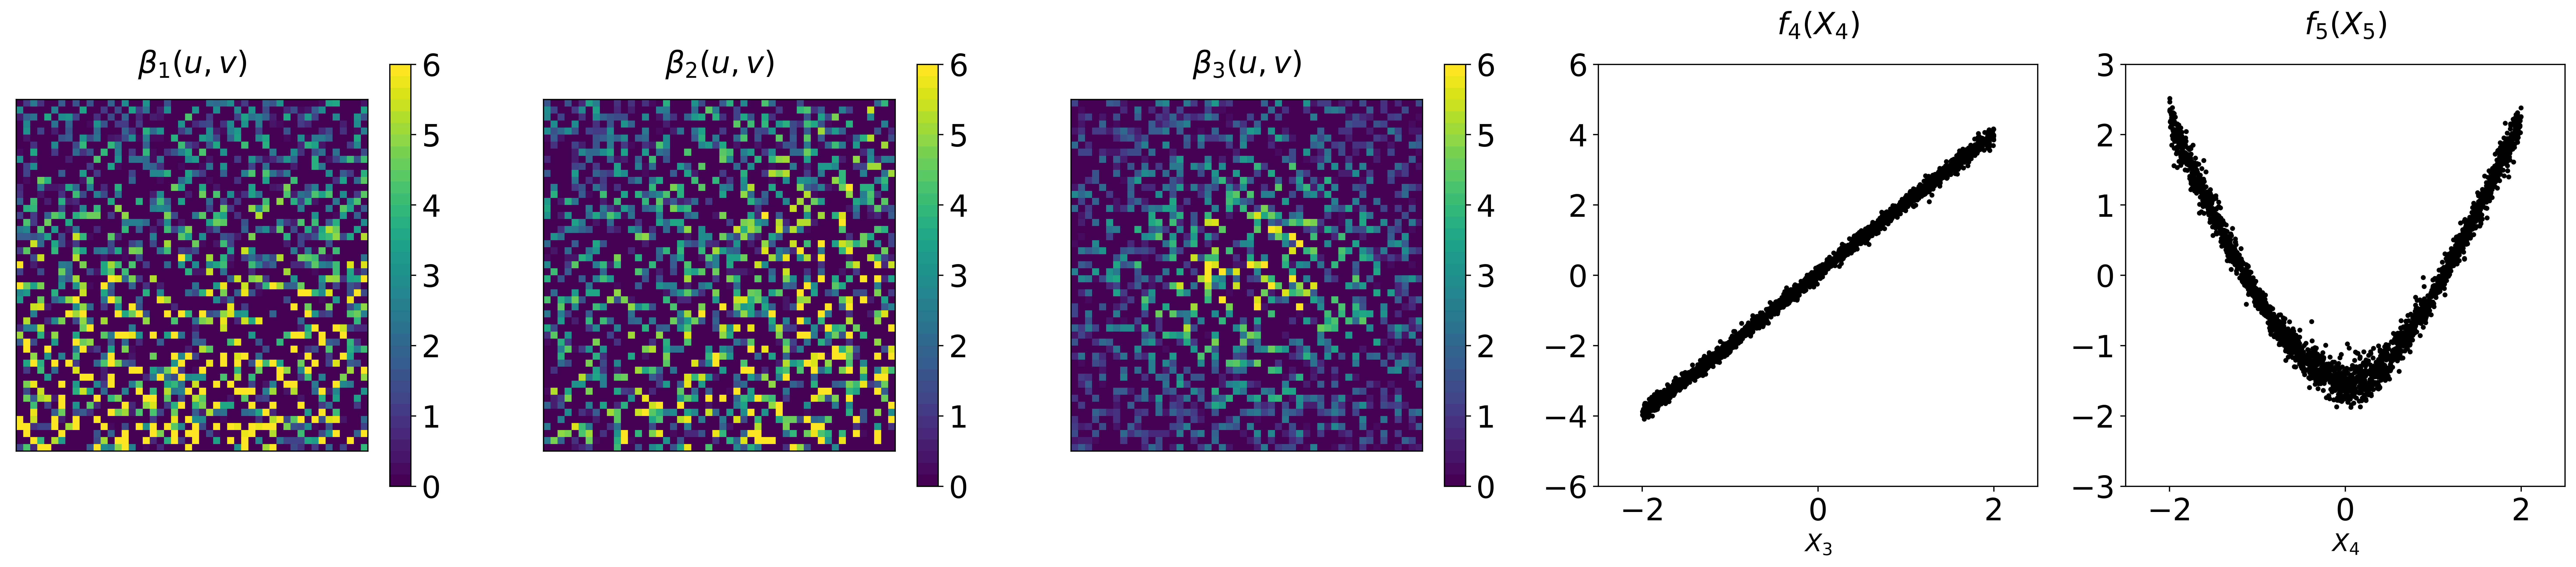

In [28]:
plot_contribution(pred_b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4])

In [29]:
X1_cover = (pred_results['X1_shap'] <= pred_results['X1_upper_bound']) & (pred_results['X1_shap'] >= pred_results['X1_lower_bound'])

In [30]:
X2_cover = (pred_results['X2_shap'] <= pred_results['X2_upper_bound']) & (pred_results['X2_shap'] >= pred_results['X2_lower_bound'])

In [31]:
X3_cover = (pred_results['X3_shap'] <= pred_results['X3_upper_bound']) & (pred_results['X3_shap'] >= pred_results['X3_lower_bound'])

In [32]:
b_cover = [X1_cover.values, X2_cover.values, X3_cover.values]

In [33]:
sub_titles = [r'$Cover_1$', r'$Cover_2$', r'$Cover_3$']

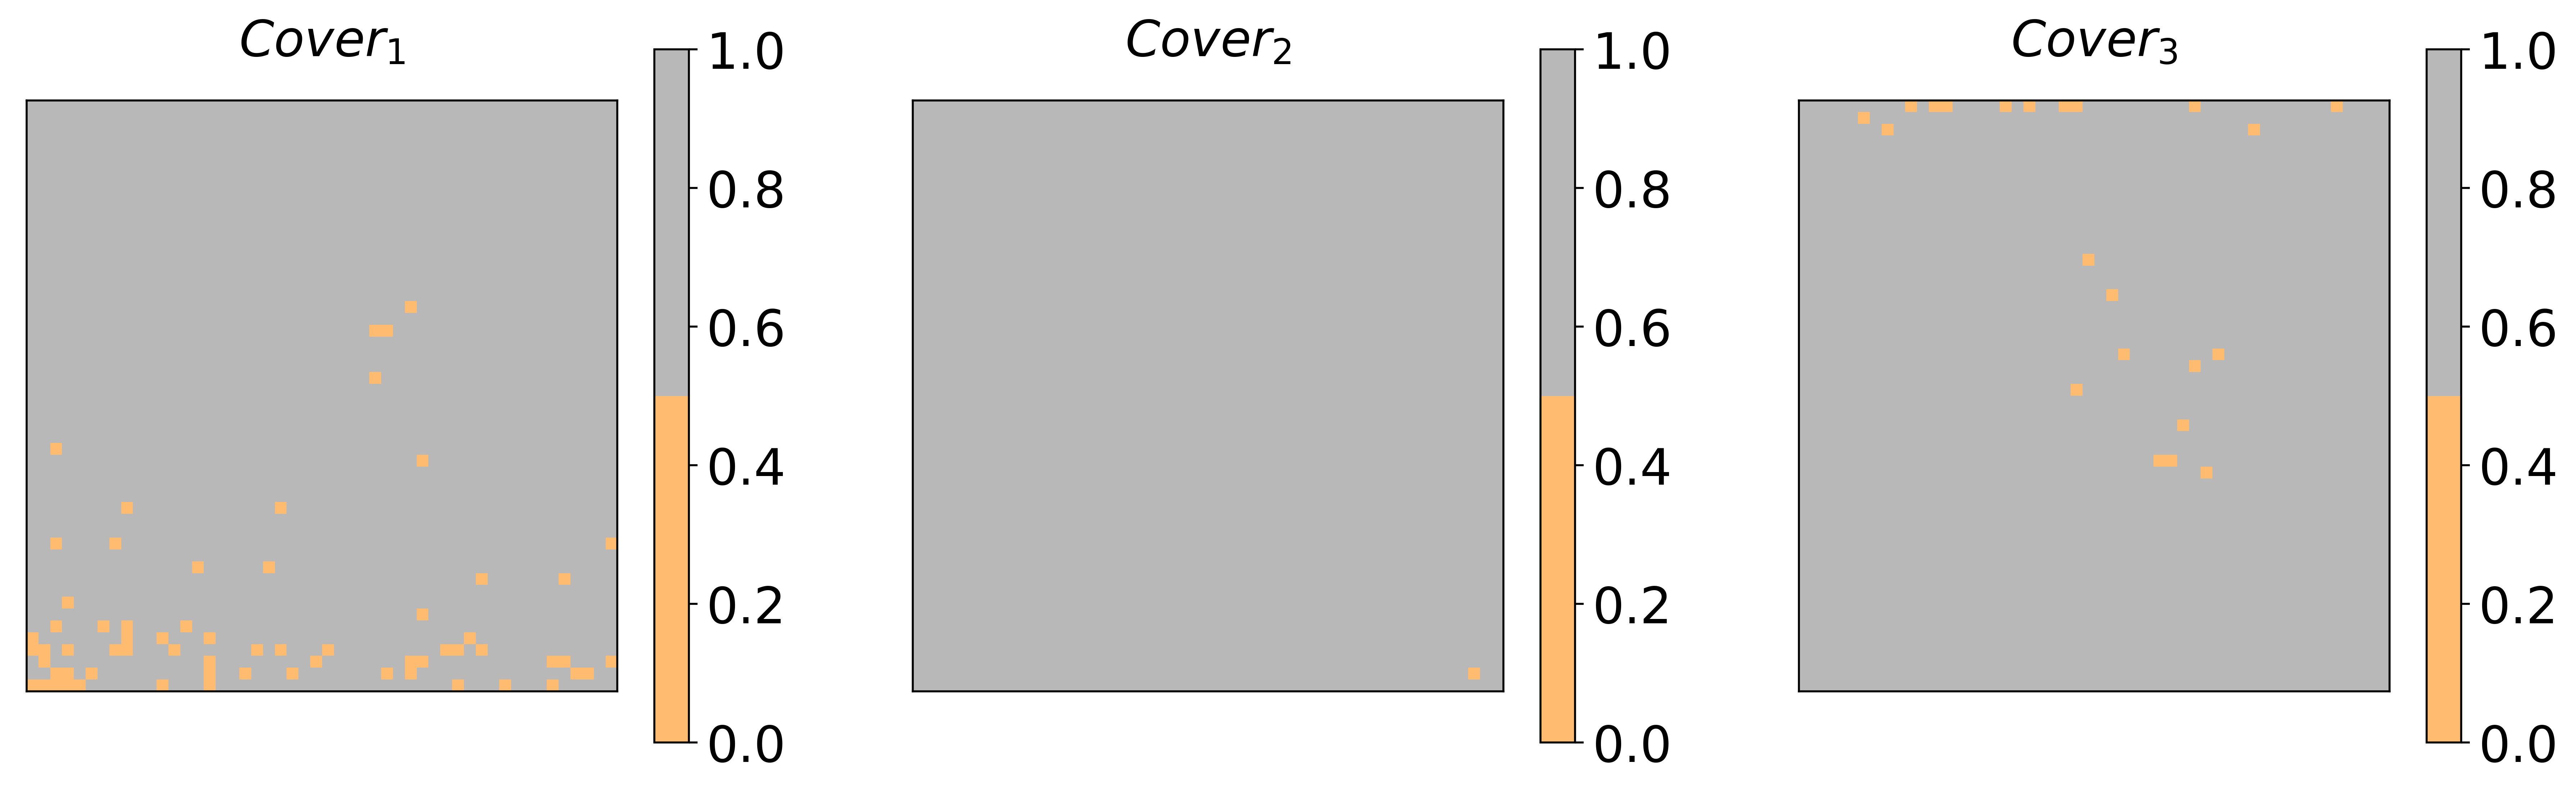

In [34]:
binary_cmap = ListedColormap(['#ffbb6f', '#b8b8b8'])
plot_contribution(b_cover, k=3, sub_titles=sub_titles, vmin=0, vmax=1, title='Coverage - ConformalSHAP', non_spatial=[], cmap=binary_cmap)

In [35]:
plt.rcParams['font.size'] = 16

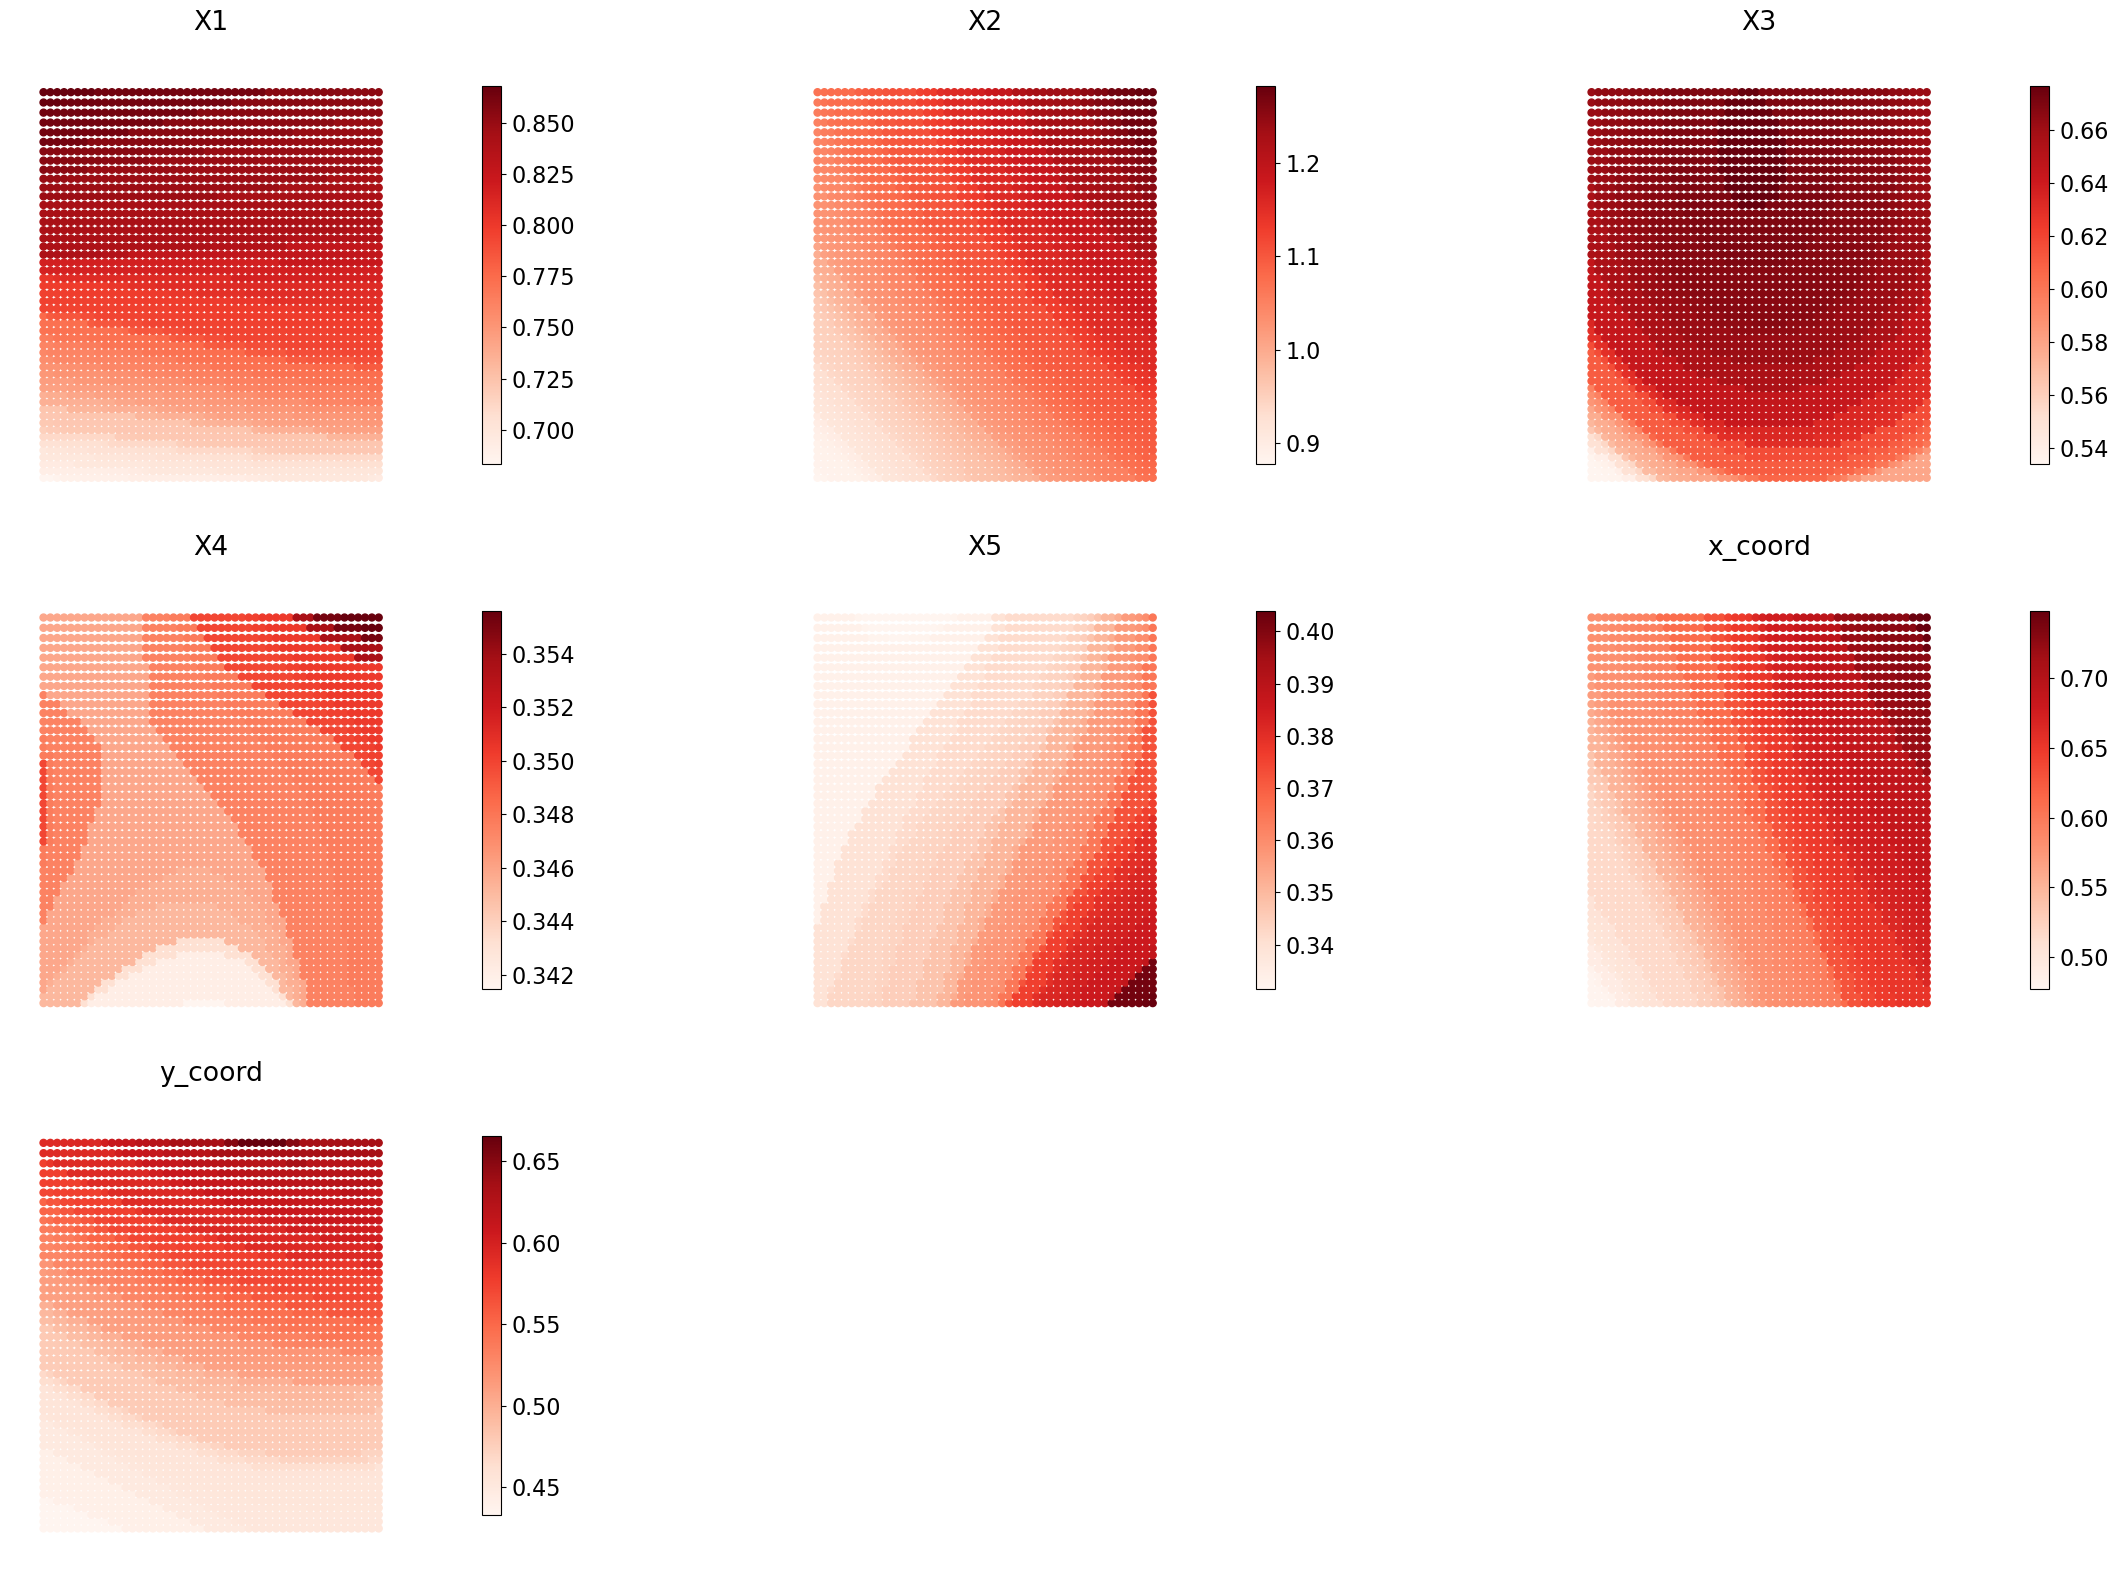

In [36]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [37]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [38]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

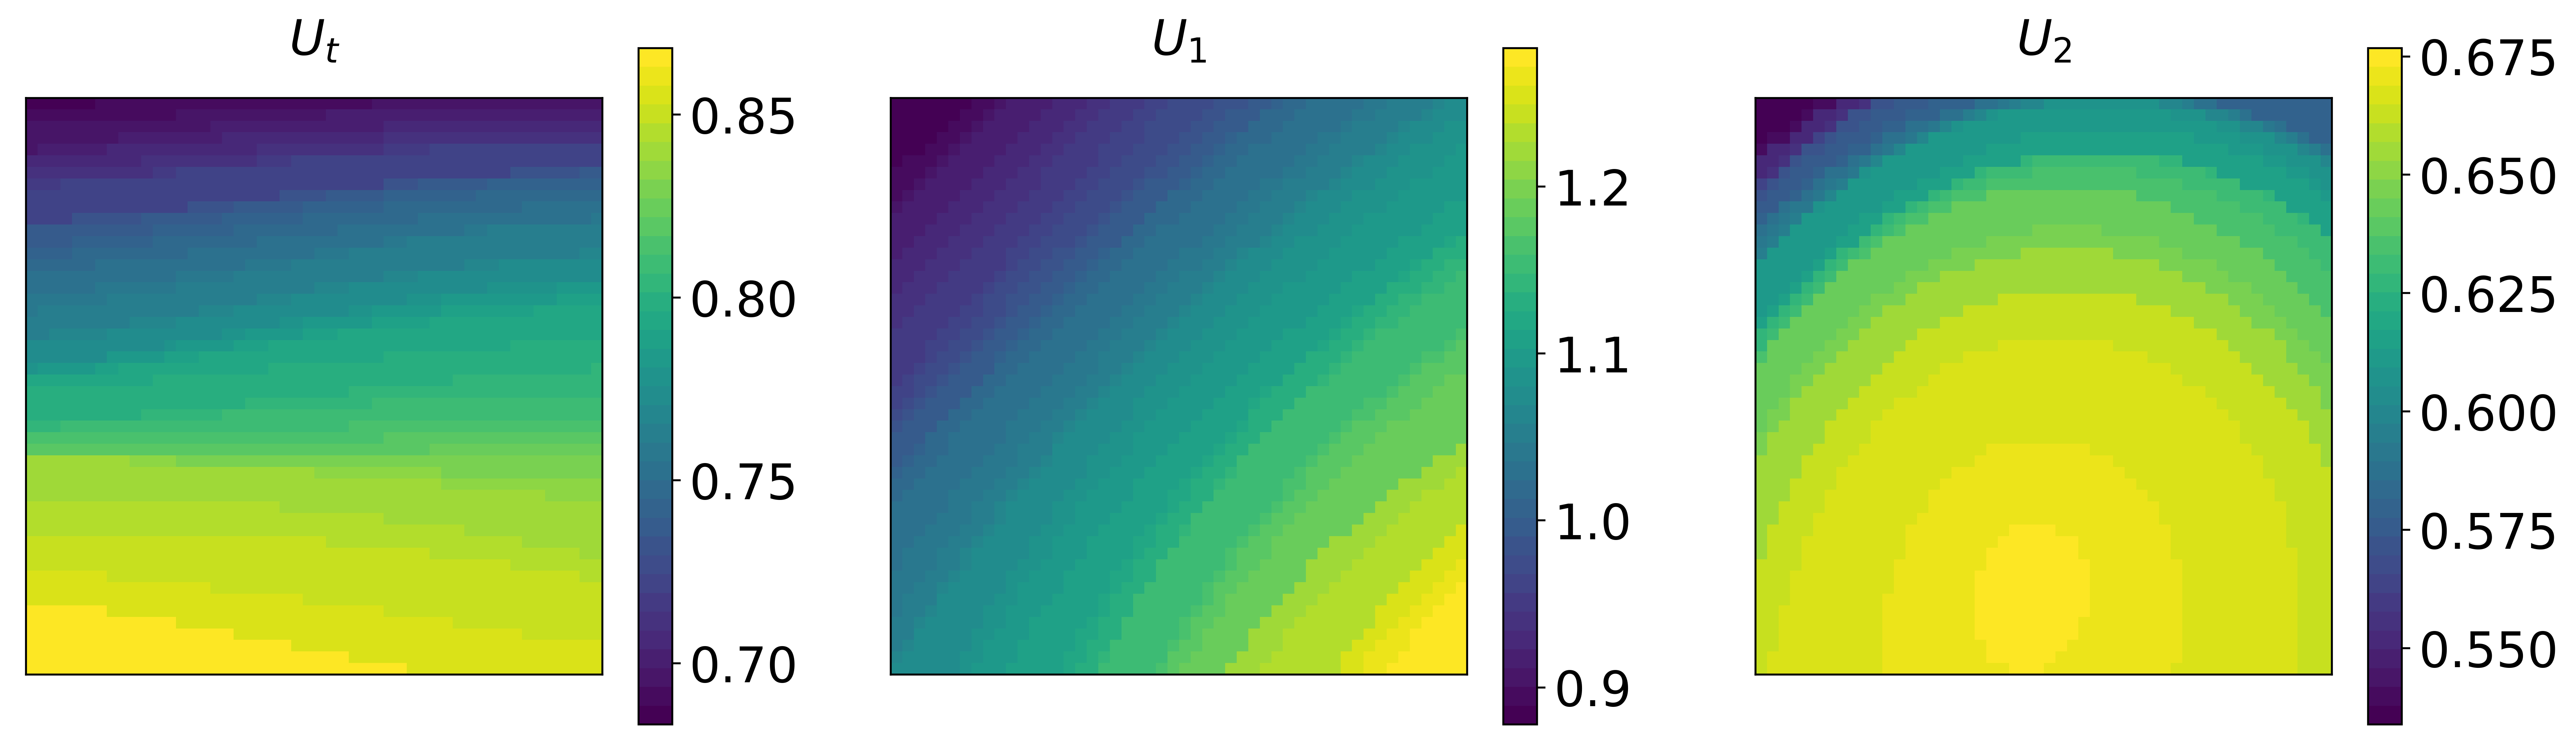

In [39]:
plot_contribution([pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=3, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

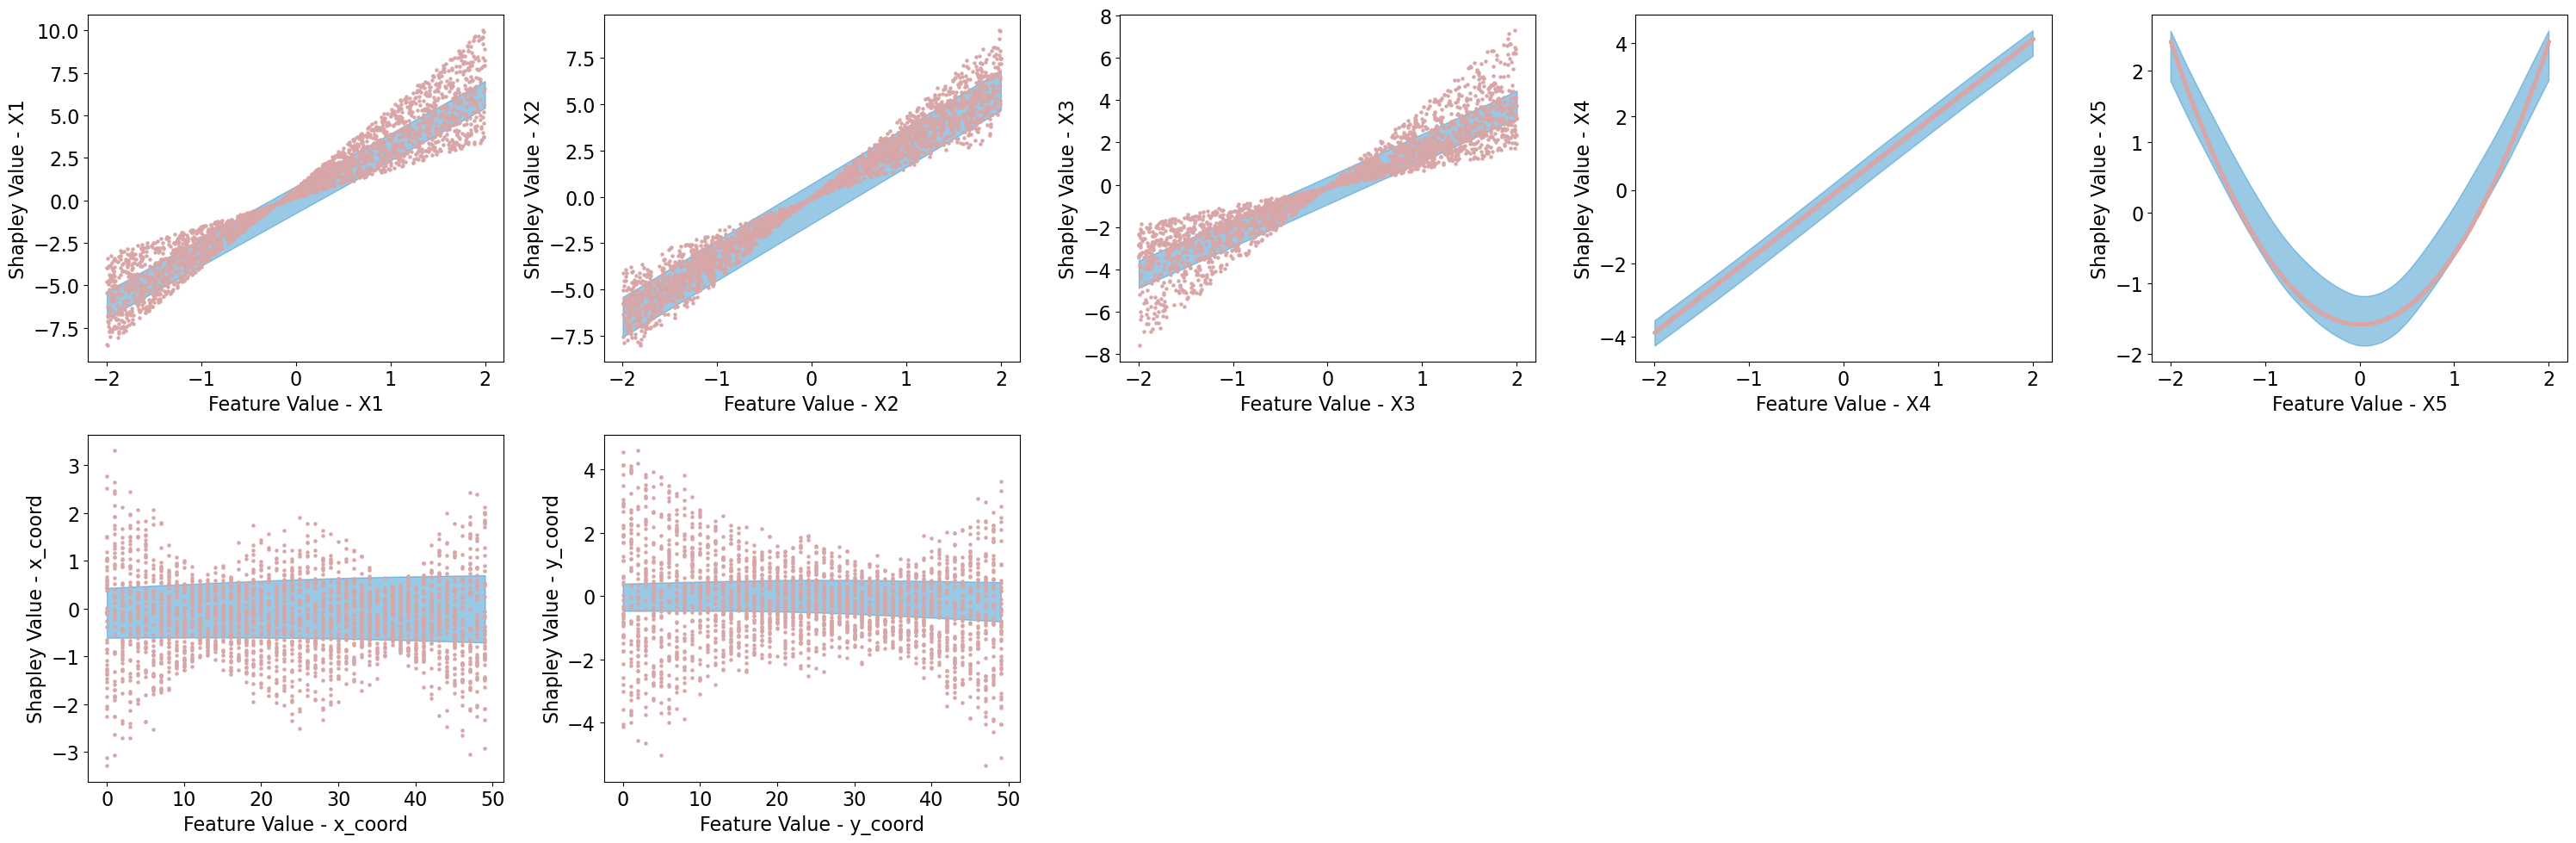

In [40]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)

In [41]:
explainer_without_uncertainty = GeoConformalizedExplainer(true_model_without_uncertainty, X_train, X_calib, loc_calib.values, loc.values, 0.1, 10)

In [42]:
results = explainer_without_uncertainty.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

ExactExplainer explainer: 2001it [01:49, 16.52it/s]                          
ExactExplainer explainer: 501it [00:34, 11.36it/s]                         
ExactExplainer explainer: 2501it [02:10, 17.60it/s]                          


In [43]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.9760  0.985621  0.454267  14.351401      13.688013
X2                     1.0000  0.989835  0.373788  13.744562      13.246048
X3                     0.9900  0.989946  0.244775   5.959096       6.105264
X4                     0.9916  0.997040  0.127668   5.507205       5.510504
X5                     0.8448  0.958686  0.241215   1.408369       1.336643
x_coord                0.9632  0.888632  0.279866   0.703302       0.627198
y_coord                0.8812  0.937937  0.338801   1.849501       1.704711

In [44]:
pred_results = results.result

In [45]:
results.result_geo

X1_shap   X2_shap   X3_shap   X4_shap   X5_shap  x_coord_shap  \
0     0.402282  1.560145  0.784895  2.591669  1.150156     -1.182780   
1     1.471923 -0.742340 -0.820640  2.256475  1.283106      0.609109   
2     2.481585 -1.491541 -1.018764 -3.776410 -1.441611      0.962861   
3     1.260048  1.854833 -1.146176 -0.640815 -1.193696     -0.423604   
4    -2.881446  0.039190 -0.630565  2.332113 -1.469569      0.109652   
...        ...       ...       ...       ...       ...           ...   
2495 -7.560012 -3.413808 -0.025156 -2.519255  2.221087     -0.571663   
2496  1.974218 -2.923845  0.419647  0.905112 -1.475219     -0.670329   
2497 -7.193156 -4.640635 -0.665105  3.224179 -1.112315     -0.556437   
2498 -2.190753 -4.707821  0.636344  4.206248  1.237160     -1.088796   
2499  4.604215 -3.370276  0.454522  1.183082  0.144450     -0.855815   

      y_coord_shap  X1_value  X2_value  X3_value  ...  x_coord_pred  \
0        -1.176394  0.104114  0.964917  1.011381  ...     -1.279858   
1        -0.322766  0.741269 -0.440030 -0.936705  ...      0.771941   
2        -0.857672  1.342697 -0.875739 -1.148677  ...      1.156272   
3        -1.198843  0.615061  1.082512 -1.266801  ...     -0.138870   
4         3.581061 -1.851912  0.026923 -0.659943  ...      0.426411   
...            ...       ...       ...       ...  ...           ...   
2495     -3.391793 -1.798074 -0.779403  0.012337  ...     -0.254482   
2496     -0.841395  0.239688 -0.666447  0.497581  ...     -0.430725   
2497     -3.160428 -1.719665 -1.038000 -0.700350  ...     -0.096862   
2498     -2.354208 -0.650496 -1.045958  0.776005  ...     -0.981167   
2499     -0.151372  0.801800 -0.750421  0.581807  ...     -0.757845   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.425305             0.499108            -0.846534   
1                    0.398739             0.499108            -0.023414   
2                    0.398739             0.499108            -0.638540   
3                    0.398739             0.499108            -0.729727   
4                    0.398739             0.499108             3.580313   
...                       ...                  ...                  ...   
2495                 0.723986             0.499108            -1.938127   
2496                 0.723986             0.499108             0.147124   
2497                 0.723986             0.499108            -1.803481   
2498                 0.723986             0.499108            -1.413207   
2499                 0.723986             0.499108             0.503192   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -1.697143                        0.8812     -1.271838   0.0   
1               -0.820891                        0.8812     -0.422153   1.0   
2               -1.436017                        0.8812     -1.037278   2.0   
3               -1.527204                        0.8812     -1.128466   3.0   
4                2.782836                        0.8812      3.181575   4.0   
...                   ...                           ...           ...   ...   
2495            -3.386099                        0.8812     -2.662113  45.0   
2496            -1.300849                        0.8812     -0.576862  46.0   
2497            -3.251454                        0.8812     -2.527467  47.0   
2498            -2.861180                        0.8812     -2.137193  48.0   
2499            -0.944781                        0.8812     -0.220795  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [46]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred', 'X5_pred']]

In [47]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, b['X3_pred'].values, [X_coords.values[:, 3], b['X4_pred'].values, -6, 6], [X_coords.values[:, 4], b['X5_pred'].values, -2, 5]]

In [48]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_{4}(X_4)$', r'$f_5(X_5)$']

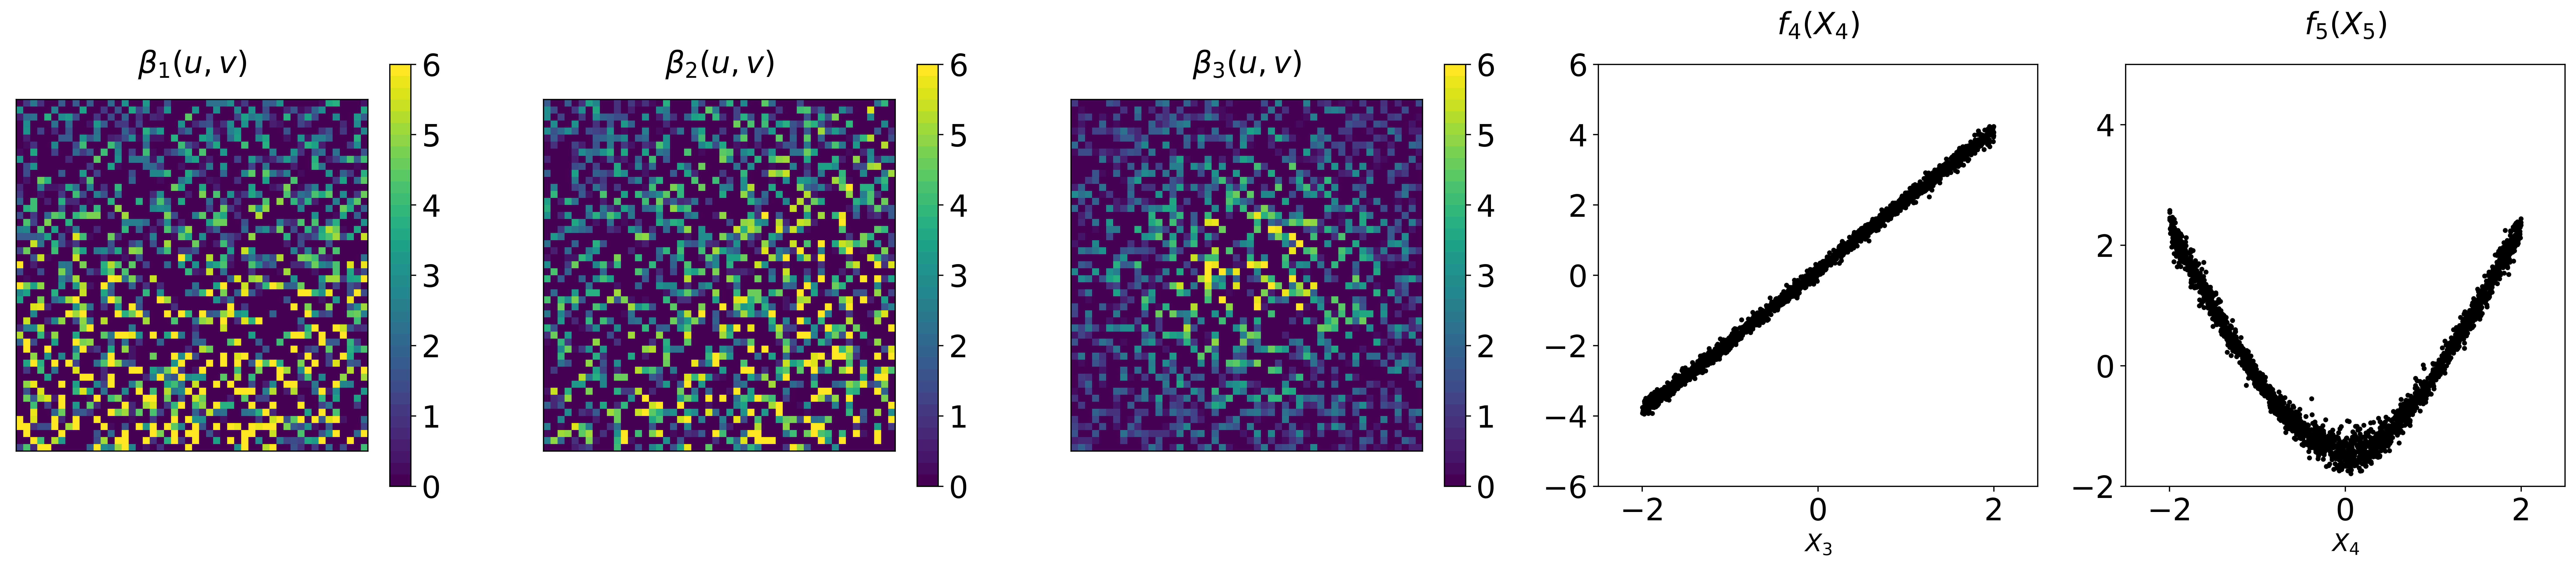

In [49]:
plot_contribution(pred_b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4])

In [50]:
plt.rcParams['font.size'] = 16

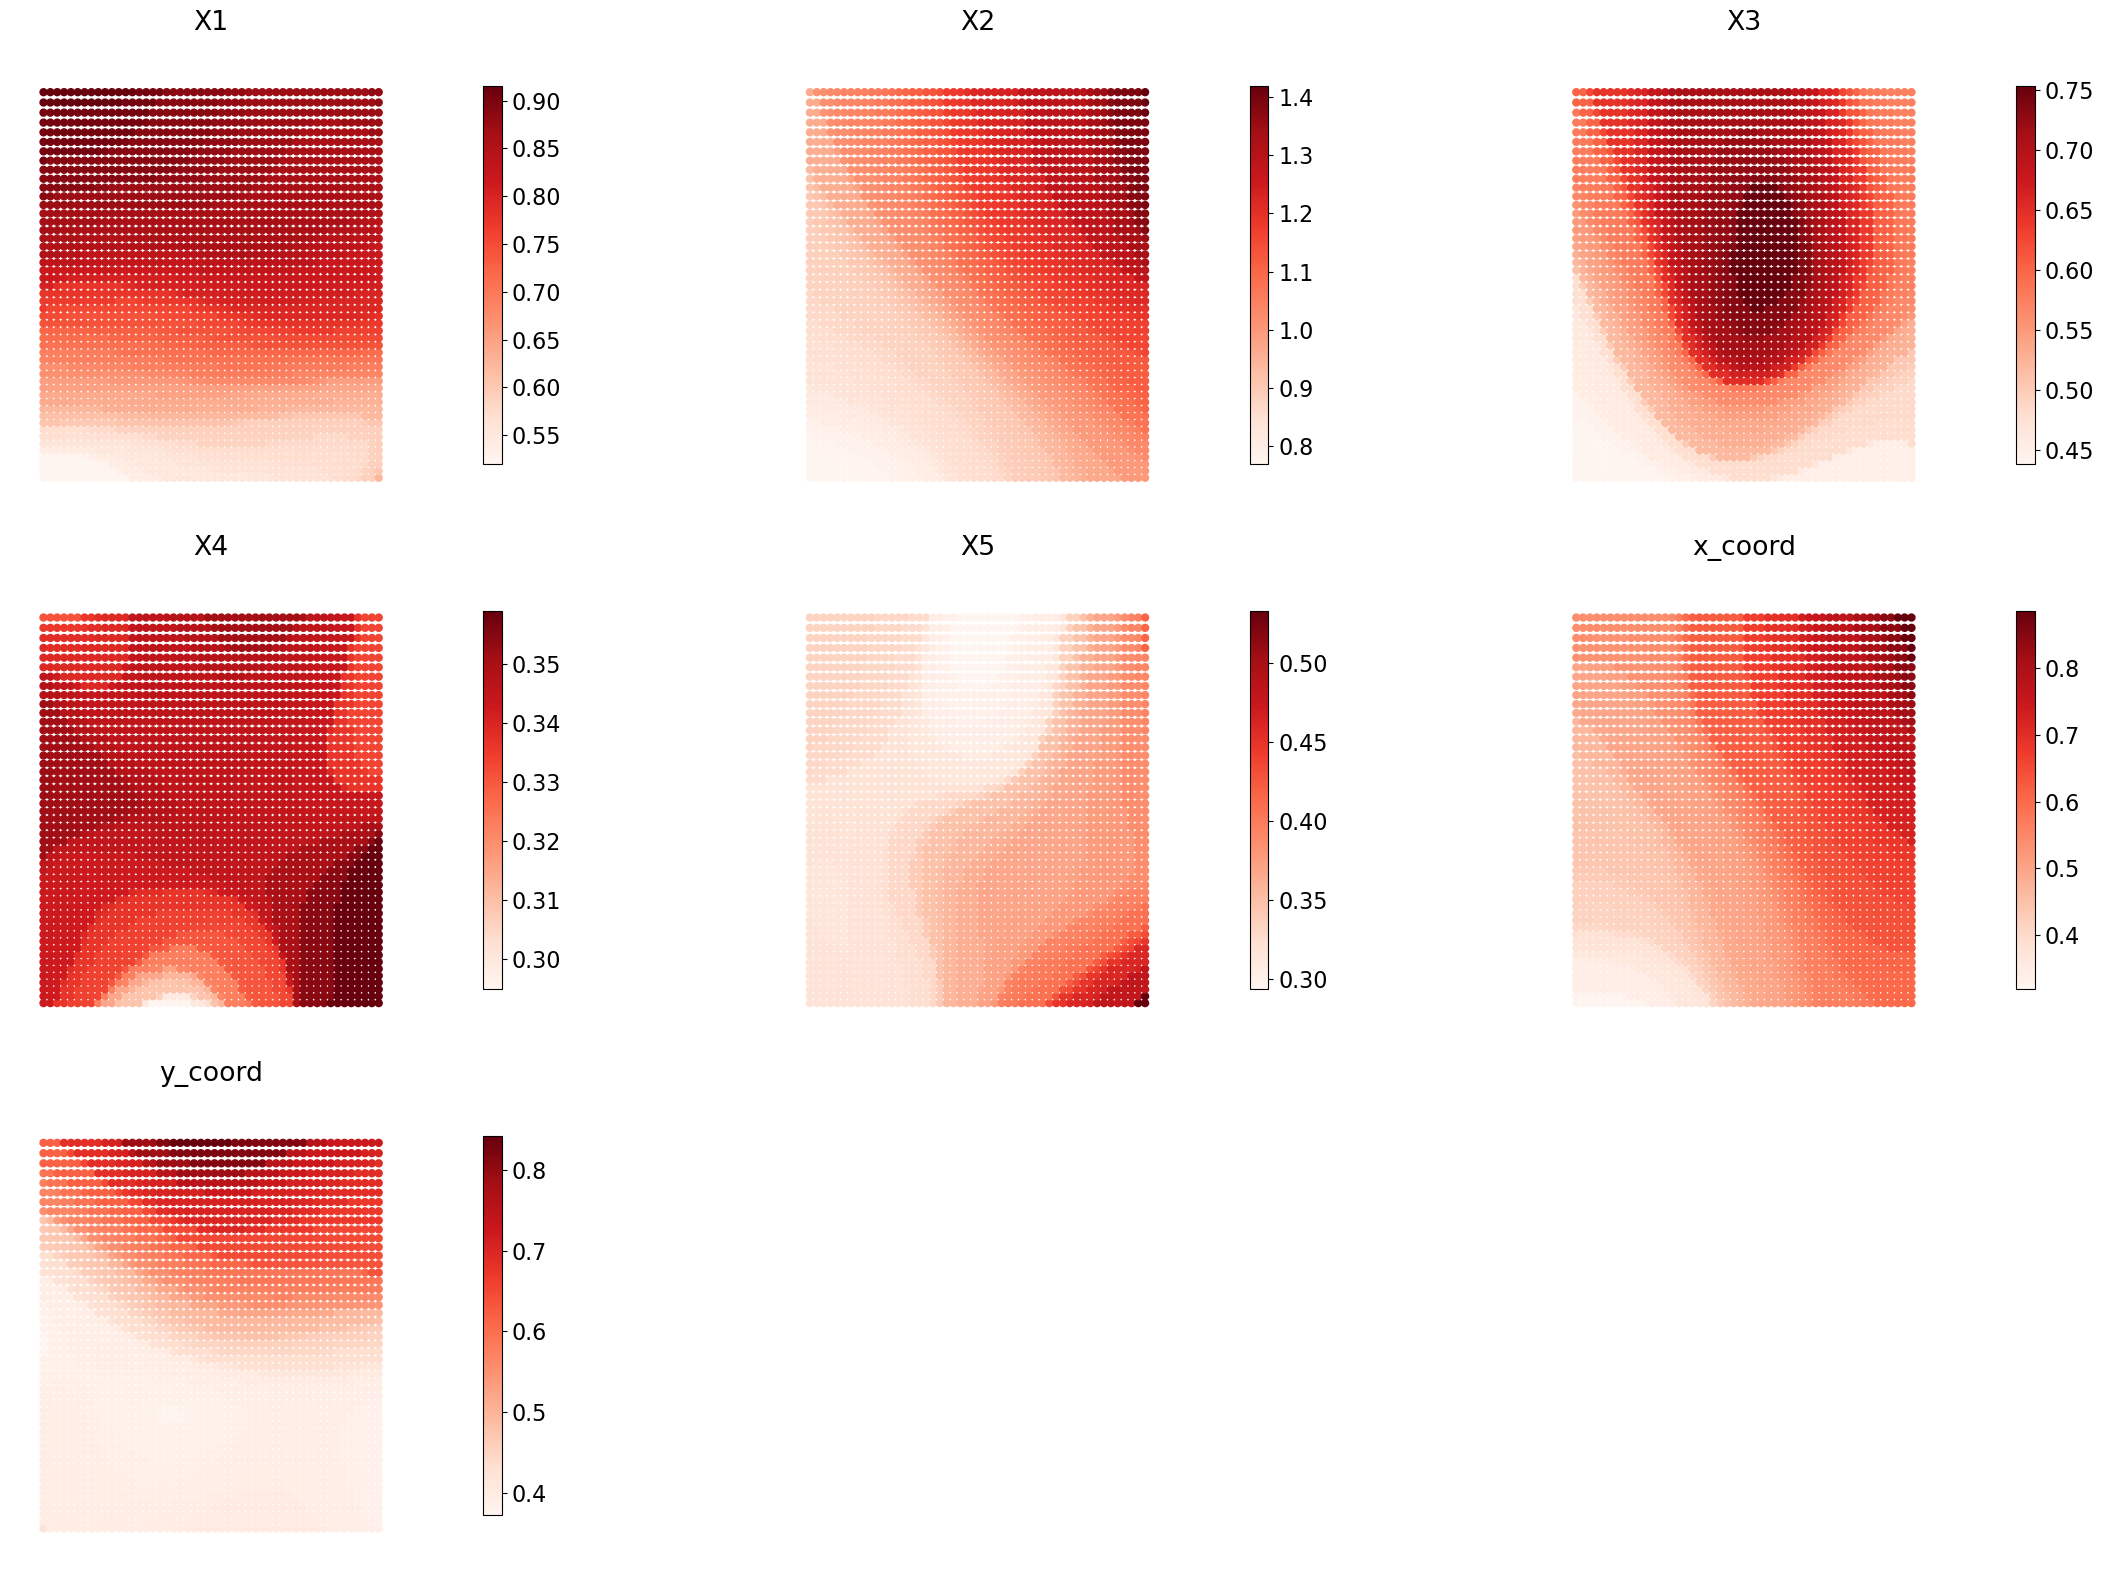

In [51]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [52]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [53]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

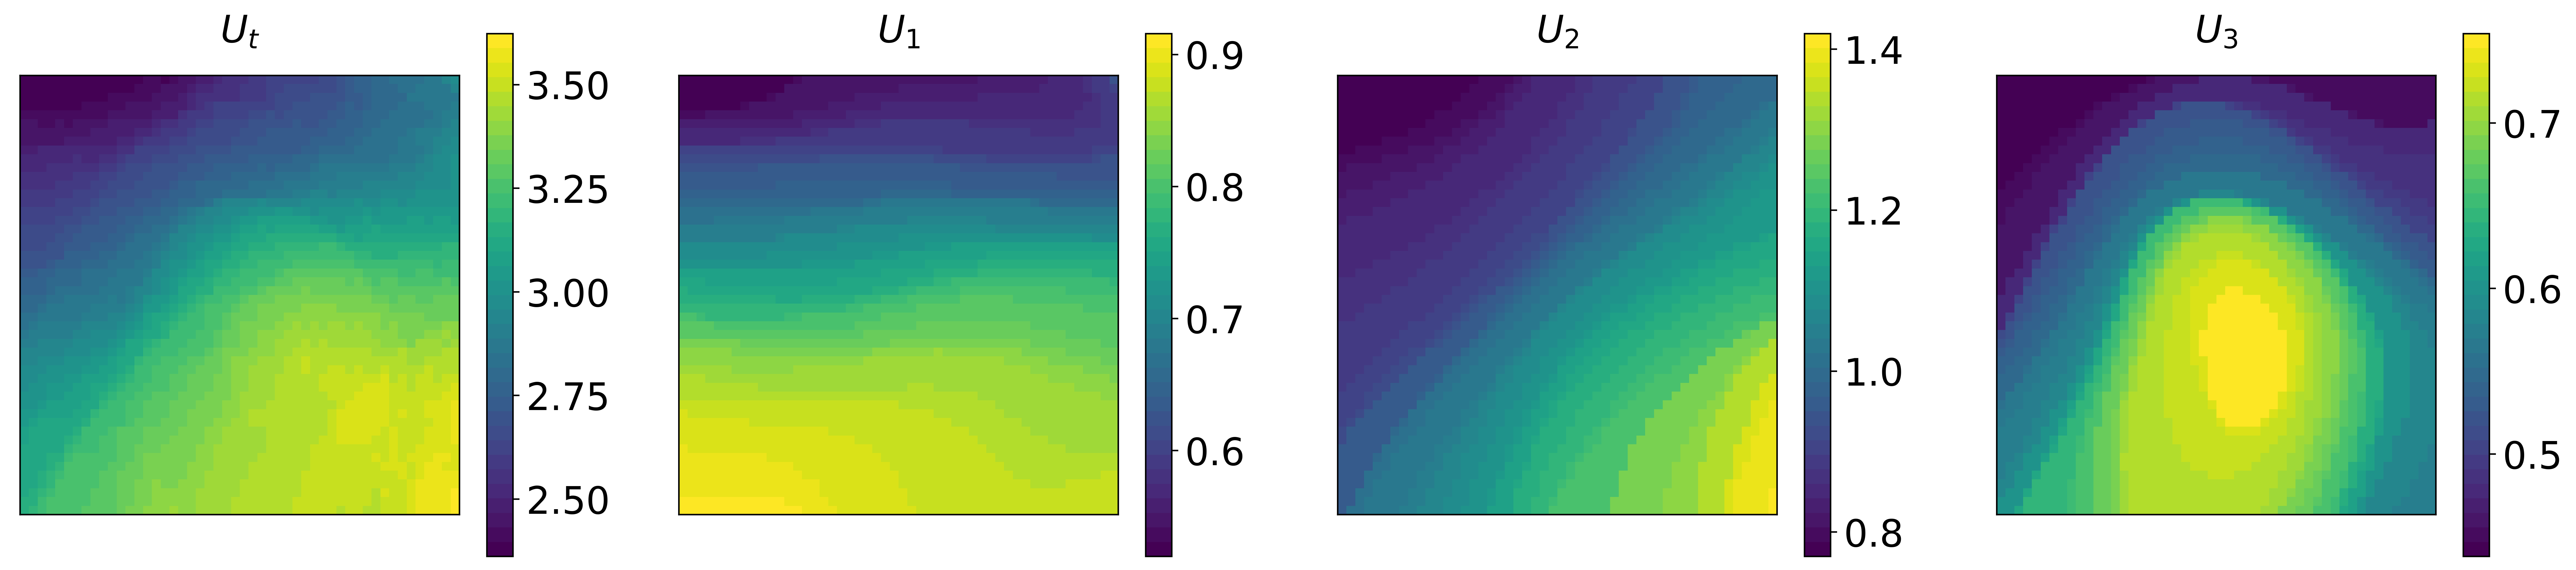

In [54]:
plot_contribution([geo_uncertainty_sum.values, pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=4, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

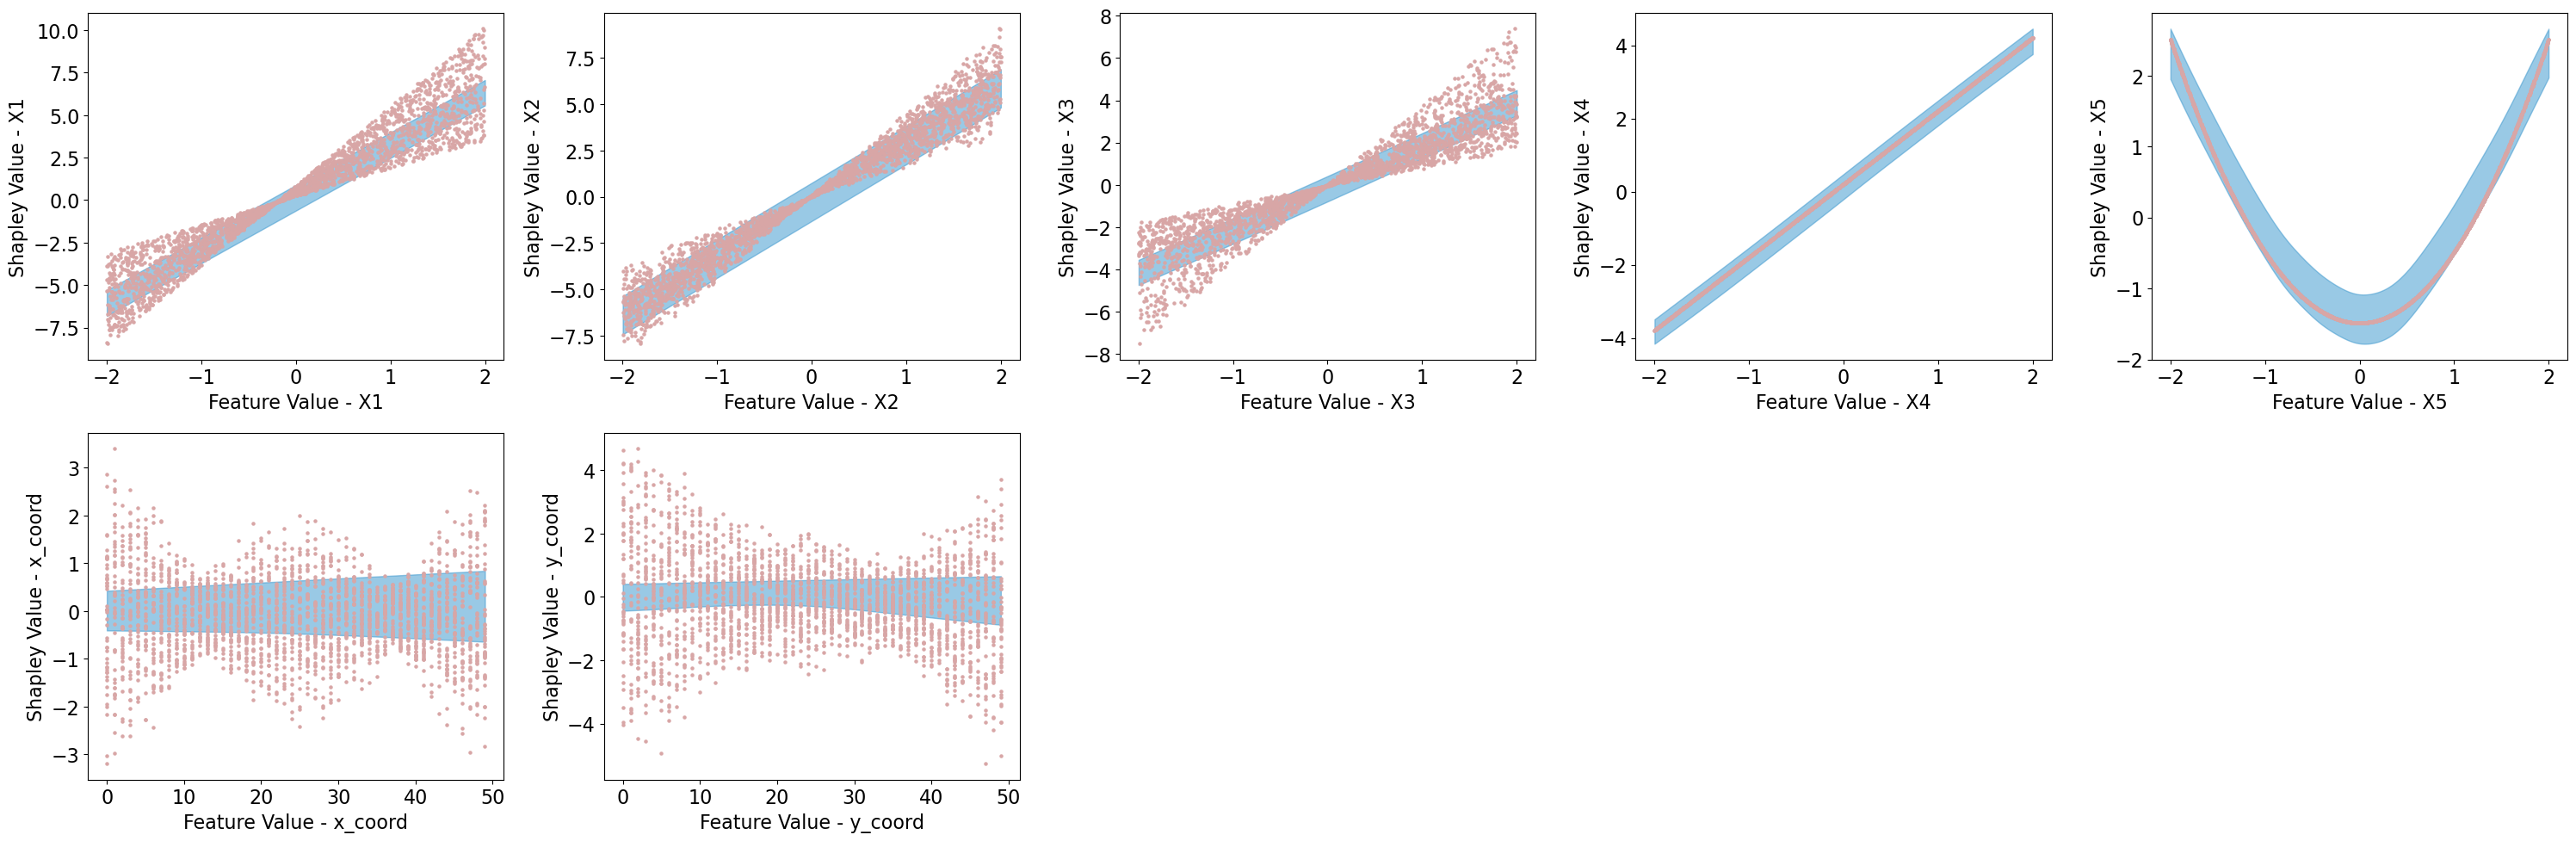

In [55]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)